In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
sns.set_palette("Blues_d")

from IPython.display import HTML

# import the widgets module
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
import scipy.io
import scipy 
import bct

In [2]:
randomized_cluster_coeffs = {10: 0.04553406294369868,
                             20: 0.05690102282478066,
                             30: 0.06127793657709912,
                             40: 0.061323656268193194,
                             50: 0.05716521136735544}

randomized_resting_cluster_coeffs = {10: 0.06446721422003235,
                                     20: 0.07079388158927634,
                                     30: 0.07710257209169963,
                                     40: 0.07941956699815134,
                                     50: 0.07575776418353161}

randomized_global_eff = {10: 0.18636043296382718,
                         20: 0.1899269043027701,
                         30: 0.19062799662645585,
                         40: 0.19080078731427177,
                         50: 0.19088647399171}

randomized_resting_global_eff = {10: 0.21708962046900715,
                                 20: 0.21942865066322428,
                                 30: 0.22013114109943568,
                                 40: 0.2199797903015698,
                                 50: 0.21998728136112966}

In [3]:
randomized_resting = {'cluster' : randomized_resting_cluster_coeffs,
                      'global' : randomized_resting_global_eff}

randomized_working = {'cluster': randomized_cluster_coeffs, 
                     'global': randomized_global_eff}

In [4]:
def normalized(val, mean):
    return val/mean

In [5]:
# function that takes in a participant's correlation matrix and 
# returns 5 matrices at different thresholds
def threshold(arr, thresholds):
    #thresholding the array
    return [bct.threshold_proportional(arr, p, copy=True) for p in thresholds]

In [6]:
def get_clustering_coeff(arr):
    return bct.clustering_coef_wu(arr)

In [7]:
def charpath(array):
    
    # converting to lengths
    array = bct.weight_conversion(array, 'lengths')
    
    # turning into distance array 
    distance_array, other_arr = bct.distance_wei(array)
    
    return bct.charpath(distance_array)[1]

In [8]:
# generate NUM_RANDOMS randomize undirected, weighted networks (working)
def randomize(array, iterations, num_randoms):
    randomizedArrays = []
    for i in range(num_randoms):
        random_arr, eff = bct.randmio_und(array, iterations)
        randomizedArrays.append(random_arr)
    return randomizedArrays

In [9]:
# generate NUM_RANDOMS randomized directed, weighted networks (resting)
def randomize_d(arr, iterations, num_randoms):
    randomizedArrays = []
    for i in range(num_randoms):
        rarr, eff = bct.randmio_dir(arr, iterations)
        randomizedArrays.append(rarr)
    return randomizedArrays

In [10]:
def standardize_metric(resting, metric, to_normalize):
    output = []
    if resting:
        arr = randomized_resting[metric]
    else:
        arr = randomized_working[metric]
    standardizedRestingClusters = []
    #standardizing resting state cluster coefficients
    count = 10
    for i in to_normalize:
        output.append(normalized(i, arr[count]))
        count += 10
    return output

In [11]:
thresholds = [.1, .2, .3, .4, .5]

resting = np.array(pd.read_csv('subj001cond001.csv'))

subOne = scipy.io.loadmat('resultsROI_Subject001_Condition002.mat')['r']


subTwo = scipy.io.loadmat('resultsROI_Subject002_Condition002.mat')['r']


subThree = scipy.io.loadmat('resultsROI_Subject003_Condition002.mat')['r']


subSeven = scipy.io.loadmat('resultsROI_Subject007_Condition002.mat')['r']


subEight = scipy.io.loadmat('resultsROI_Subject018_Condition002.mat')['r']


subNine = scipy.io.loadmat('resultsROI_Subject019_Condition002.mat')['r']

In [30]:
working_states = [subOne, subTwo, subThree, 
                  subSeven, subEight]

In [31]:
thresholded_working_states = {}
subject_numbers = [1, 2, 3, 7, 8]
j = 0

for i in working_states:
    thresholded_working_states[subject_numbers[j]] = threshold(i, thresholds)
    j += 1

In [32]:
resting_states = threshold(resting, thresholds)

resting_clusters = [get_clustering_coeff(i) for i in resting_states]

resting_avg_clusters = [np.mean(i) for i in resting_clusters]

resting_standardized_clusters = standardize_metric(True, 'cluster', resting_avg_clusters)

resting_efficiencies = [charpath(arr) for arr in resting_states]

standardized_resting_efficiencies = standardize_metric(True, 'global', resting_efficiencies)

In [15]:
resting_standardized_clusters

[2.3592001232570525,
 1.9043640234494228,
 1.599061710899723,
 1.4089266870648813,
 1.3002291017365912]

In [16]:
standardized_resting_efficiencies

[0.8411581349922793,
 0.8591976667650834,
 0.8612192127784455,
 0.8619204300828786,
 0.8618910797620888]

In [34]:
working_clusters = {}
working_efficiencies = {}

for i in subject_numbers:
    working_clusters[i] = [get_clustering_coeff(j) for j in thresholded_working_states[i]]
    working_efficiencies[i] = [charpath(j) for j in thresholded_working_states[i]]

In [ ]:
working_avg_clusters = {}


for i in subject_numbers:
    working_avg_clusters[i] = [np.mean(j) for j in working_clusters[i]]

The way we are aggregating is we are: 

-- collecting average clustering coefficient values for each participant at each treshold
-- adding up the averaged clustering coefficients accross participants, then averaging the summed values  
-- standardizing the values with respect to the randomized network metrics

In [35]:
summed_working_avg_clusters = {}
summed_working_efficiencies = {}

for i in np.arange(10, 60, 10):
    summed_working_avg_clusters[i] = 0
    summed_working_efficiencies[i] = 0

for i in subject_numbers:
    j = 10
    for n in working_avg_clusters[i]:
        summed_working_avg_clusters[j] += n
        j += 10
    j = 10
    for n in working_efficiencies[i]:
        summed_working_efficiencies[j] += n
        j += 10

for i in list(summed_working_avg_clusters.keys()):
    new_val = summed_working_avg_clusters[i] / 6
    summed_working_avg_clusters[i] = new_val
    

for i in list(summed_working_efficiencies.keys()):
    new_val = summed_working_efficiencies[i] / 6
    summed_working_efficiencies[i] = new_val

In [ ]:
summe

In [39]:
summed_working_efficiencies

{10: 0.12501236979888702,
 20: 0.12816437694735616,
 30: 0.12824494453315063,
 40: 0.128245520407415,
 50: 0.128245520407415}

In [40]:
vals = list(summed_working_avg_clusters.values())

eff_vals = list(summed_working_efficiencies.values())

standardized_cluster_coeffs = standardize_metric(False, 'cluster', vals)

standardized_efficiencies = standardize_metric(False, 'global', eff_vals)

In [41]:
standardized_efficiencies

[0.6708096123770656,
 0.6748089609413324,
 0.6727497891322458,
 0.6721435598490443,
 0.6718418425654642]

# Clustering Coefficient

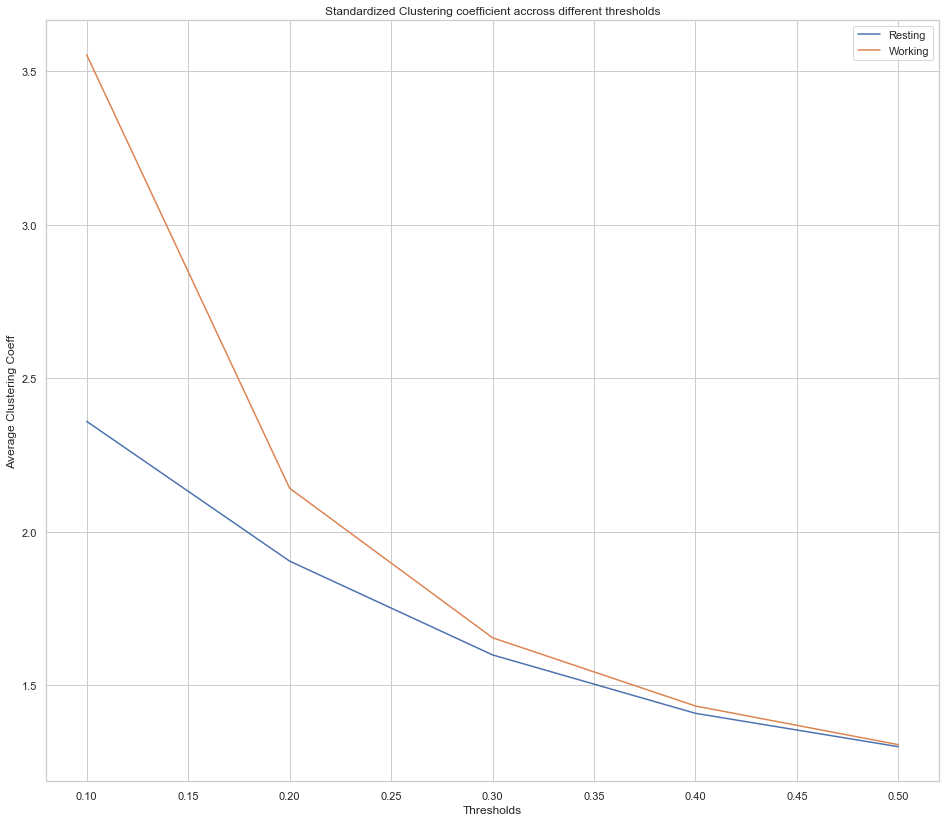

In [23]:
# Plotting the average clustering coefficient accross different thresholds

f, ax = plt.subplots(1, 1)
f.set_size_inches(16, 14)
sns.lineplot(x=thresholds, y=resting_standardized_clusters)
sns.lineplot(x=thresholds, y=standardized_cluster_coeffs)
ax.legend(['Resting', 'Working']);
ax.set(xlabel='Thresholds', ylabel='Average Clustering Coeff', 
       title='Standardized Clustering coefficient accross different thresholds');

# Global Efficiency

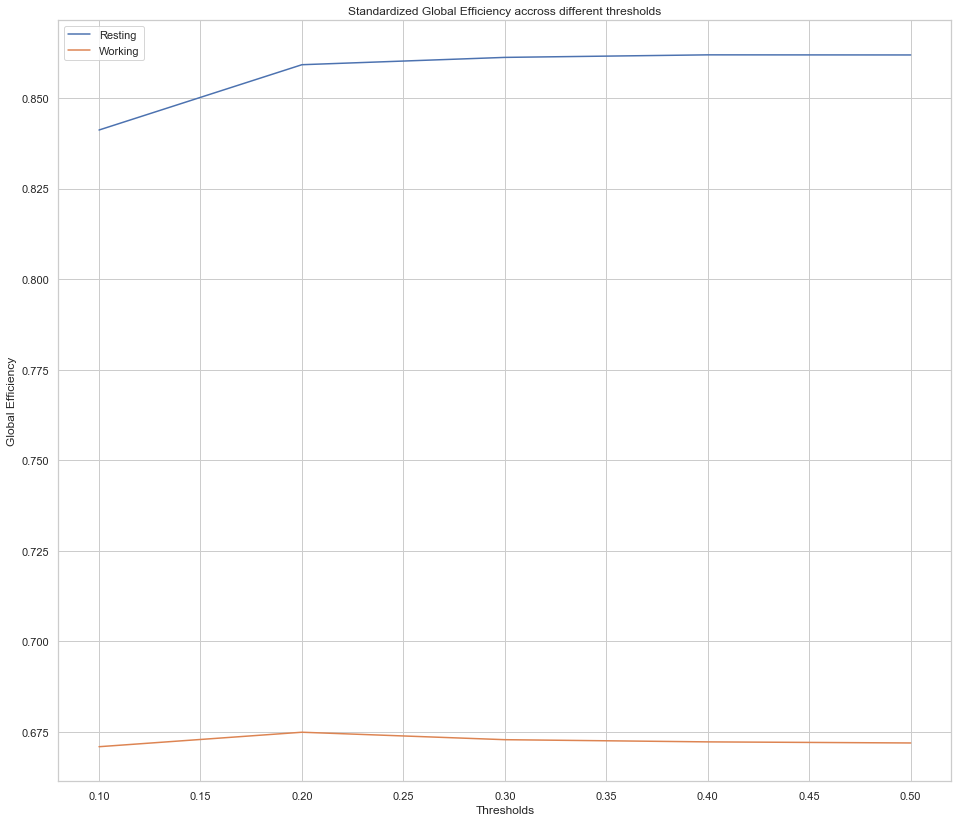

In [37]:
# Plotting the average clustering coefficient accross different thresholds

f, ax = plt.subplots(1, 1)
f.set_size_inches(16, 14)
sns.lineplot(x=thresholds, y=standardized_resting_efficiencies)
sns.lineplot(x=thresholds, y=standardized_efficiencies)
ax.legend(['Resting', 'Working']);
ax.set(xlabel='Thresholds', ylabel='Global Efficiency', 
       title='Standardized Global Efficiency accross different thresholds');